In [1]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import os
import numpy as np

video_path = os.path.join('data', 'input', '10 menit 1 November.mp4')

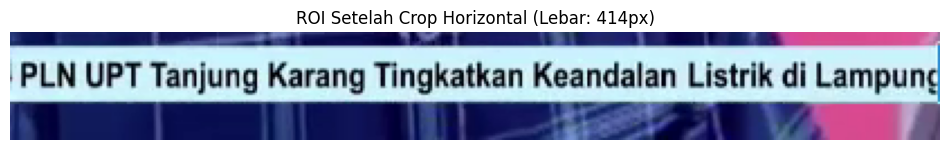

In [91]:
# Ambil frame spesifik
frame_number = 9922
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
cap.release()

# 1. Crop vertikal: 10% bagian bawah
height, width = frame.shape[:2]
roi = frame[int(0.9*height):height, :, :].copy()

# 2. Crop horizontal: HILANGKAN LOGO & TIMESTAMP
# Sesuaikan nilai ini berdasarkan gambar Anda:
left_crop = 179  # Potong 120px dari kiri (untuk logo)
right_crop = 127  # Potong 100px dari kanan (untuk timestamp)
refined_roi = roi[:, left_crop:width-right_crop, :].copy()

# Tampilkan ROI hasil crop
plt.figure(figsize=(12, 3))
plt.imshow(cv2.cvtColor(refined_roi, cv2.COLOR_BGR2RGB))
plt.title(f'ROI Setelah Crop Horizontal (Lebar: {refined_roi.shape[1]}px)')
plt.axis('off')
plt.show()

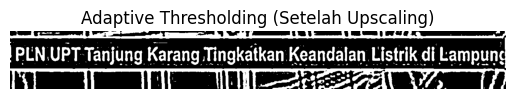

In [92]:
# Code Cell 3 (Diperbaiki)
# 1. Rescale ke 300% sebelum preprocessing
resized_roi = cv2.resize(refined_roi, (0,0), fx=3, fy=3, interpolation=cv2.INTER_CUBIC)

# 2. Gunakan adaptive thresholding (lebih baik untuk kontras rendah)
gray = cv2.cvtColor(resized_roi, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0)  # Lebih kuat dari median blur
thresh = cv2.adaptiveThreshold(
    blurred, 
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 
    19, 
    2
)

# Tampilkan hasil
plt.imshow(thresh, cmap='gray')
plt.title('Adaptive Thresholding (Setelah Upscaling)')
plt.axis('off')
plt.show()

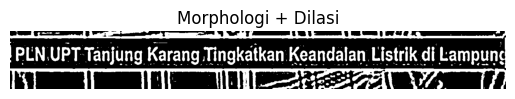

In [93]:
# Code Cell 5 (Diperbaiki)
# 1. Gunakan kernel lebih besar untuk morphologi
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

# 2. Tambahkan dilasi untuk memperjelas teks
dilated = cv2.dilate(closed, kernel, iterations=1)

# Tampilkan hasil
plt.imshow(dilated, cmap='gray')
plt.title('Morphologi + Dilasi')
plt.axis('off')
plt.show()

Teks yang Terdeteksi:
PLN.UPT Tanjung Karang Tingkatkan Keandalan Listrik di Lampung


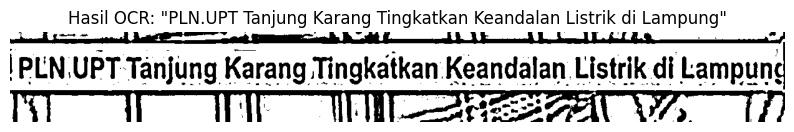

In [94]:
# Code Cell 6: OCR dengan Tesseract (Bahasa Indonesia)
# Konversi ke format yang sesuai untuk OCR (hitam-putih dengan teks hitam)
ocr_ready = cv2.bitwise_not(dilated)  # Inversi agar teks berwarna hitam

# Lakukan OCR dengan konfigurasi optimal untuk teks pendek
# Code Cell 6 (Diperbaiki)
custom_config = r'--oem 1 --psm 6 -l ind --dpi 900'
text = pytesseract.image_to_string(dilated, config=custom_config)

# Tampilkan hasil
print("Teks yang Terdeteksi:")
print("="*50)
print(text.strip())
print("="*50)

# Visualisasi hasil akhir dengan teks
plt.figure(figsize=(10, 3))
plt.imshow(ocr_ready, cmap='gray')
plt.title(f'Hasil OCR: "{text.strip()}"')
plt.axis('off')
plt.show()